In [1]:
#import packaging de base
import pandas as pd
import numpy as np

#import packaging dataviz 
import seaborn as sns
import matplotlib.pyplot as plt

#import packaging statistiques : 
from scipy.stats import chi2_contingency as khi2


#import packaging preprocessing : 
from sklearn.preprocessing import OrdinalEncoder


#import packaging train test split et selection de modèle : 
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV

#Import packaging de modèle : 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

#import packaging mesures modèle : 
from sklearn.metrics import mean_squared_error, make_scorer



# import packaging pour la feature selection :
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## 1. Analyse BDD : 
- features, target : 80, 1 (continues, price)
- 1460 observations
- Présence de NaN : **Attention** pour certaines colonnes, les NaN sont synonymes **d'information** concernant l'absence d'un element

## 2. Imputing  / Analyse univariée:
- Remplacer les NaN porteur d'informations par une valeur (0, ou 'No' par ex)
- Il faut supprimer les vrais NaN 

## 3. Analyse bivariée 
- Etude de la corrélation entre la target et les variables continues/catégoriques

## 4. Encodage & normalisation des données
* D'abord on encode les variables catégoriques
* Séparation du jeu de données en train et test set
* normalisation des données numériques continues sur la base du train set

## 5. Modélisation du jeu de donnée
* instanciation du modèle
* mesure de la performence du modèle 

## 6. Amélioration du jeu de donnée
* GridSearchCV

# 1. Analyse du jeu de données


In [2]:
path = 'D:\\formation_data_scientist\\01_Cours\\007_machine_learning\\004_Linear_Regression\\train.csv'
house = pd.read_csv(path)
df = house.copy()

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 81)

In [5]:
df.isnull().sum()[df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## Séparation des variables : 

Rappel type de variables : 
- Variables quantitatives = continues & discrètes
- Variables qualitatives = nominales & ordinales


On va procéder de la façon suivantes : 
- Séparation des variables qualitatives (ordinales + nominales) = **var_qual**
- Séparation des variables quantitatives dicrètes = **var_dis**
- Séparation des variables quantitatives continues = **var_cont**
- Regroupement de var_dis et var_qual = **var_cat**

In [6]:
#Récupérons d'abord les variables qualitatives :
var_qual = []
for i in df.select_dtypes(include = 'object'):
    col = df[i]
    print(f'{i:-<20} {col.dtypes} : {col.unique()[:5]}  ({col.nunique()})')
    var_qual.append(i)

MSZoning------------ object : ['RL' 'RM' 'C (all)' 'FV' 'RH']  (5)
Street-------------- object : ['Pave' 'Grvl']  (2)
Alley--------------- object : [nan 'Grvl' 'Pave']  (2)
LotShape------------ object : ['Reg' 'IR1' 'IR2' 'IR3']  (4)
LandContour--------- object : ['Lvl' 'Bnk' 'Low' 'HLS']  (4)
Utilities----------- object : ['AllPub' 'NoSeWa']  (2)
LotConfig----------- object : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']  (5)
LandSlope----------- object : ['Gtl' 'Mod' 'Sev']  (3)
Neighborhood-------- object : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel']  (25)
Condition1---------- object : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe']  (9)
Condition2---------- object : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN']  (8)
BldgType------------ object : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']  (5)
HouseStyle---------- object : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer']  (8)
RoofStyle----------- object : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat']  (6)
RoofMatl------------ object : ['CompShg' 

On a aisément récupérer les variables **qualitatives**, car ici toutes les variables ci-dessus ne sont pas de types numériques.
- Pour la récupération des variables numériques, on va ajouter une condition pour simplifier la séparation.

    - On va afficher les variables pouvant prendre **moins de 20 valeurs différentes**, logiquement, il y a de forte chance qu'on est uniquement des **variables discrètes**. 

In [7]:
var_dis_1 = []
for i in df.select_dtypes(exclude = 'object'):
    col = df[i]
    if col.nunique()<20:
        print(f'{i:-<20} ({col.dtypes}) : {col.unique()[:5]}  ({col.nunique()})')
        var_dis_1.append(i)

MSSubClass---------- (int64) : [ 60  20  70  50 190]  (15)
OverallQual--------- (int64) : [7 6 8 5 9]  (10)
OverallCond--------- (int64) : [5 8 6 7 4]  (9)
BsmtFullBath-------- (int64) : [1 0 2 3]  (4)
BsmtHalfBath-------- (int64) : [0 1 2]  (3)
FullBath------------ (int64) : [2 1 3 0]  (4)
HalfBath------------ (int64) : [1 0 2]  (3)
BedroomAbvGr-------- (int64) : [3 4 1 2 0]  (8)
KitchenAbvGr-------- (int64) : [1 2 3 0]  (4)
TotRmsAbvGrd-------- (int64) : [8 6 7 9 5]  (12)
Fireplaces---------- (int64) : [0 1 2 3]  (4)
GarageCars---------- (int64) : [2 3 1 0 4]  (5)
PoolArea------------ (int64) : [  0 512 648 576 555]  (8)
MoSold-------------- (int64) : [ 2  5  9 12 10]  (12)
YrSold-------------- (int64) : [2008 2007 2006 2009 2010]  (5)


* On voit aussi qu'on a facilement récupérer (une partie ?) des variables discrètes.
* Regardons si dans notre seconde condition, il n'y a que des variables quantitatives continues ou non :


In [8]:
for i in df.select_dtypes(exclude = 'object'):
    col = df[i]
    if (col.nunique() >=20 ):
        print(f'{i:-<20} ({col.dtypes}) : {col.unique()[:5]}  ({col.nunique()})')
#On s'aperçoit ici qu'on a un mélange de variables quantitatives continues et discrètes.
# Donc on va récupérer manuellement  les variables discrètes : 
var_dis_2 = ['Id','YearBuilt','YearRemodAdd','GarageYrBlt']

Id------------------ (int64) : [1 2 3 4 5]  (1460)
LotFrontage--------- (float64) : [65. 80. 68. 60. 84.]  (110)
LotArea------------- (int64) : [ 8450  9600 11250  9550 14260]  (1073)
YearBuilt----------- (int64) : [2003 1976 2001 1915 2000]  (112)
YearRemodAdd-------- (int64) : [2003 1976 2002 1970 2000]  (61)
MasVnrArea---------- (float64) : [196.   0. 162. 350. 186.]  (327)
BsmtFinSF1---------- (int64) : [706 978 486 216 655]  (637)
BsmtFinSF2---------- (int64) : [  0  32 668 486  93]  (144)
BsmtUnfSF----------- (int64) : [150 284 434 540 490]  (780)
TotalBsmtSF--------- (int64) : [ 856 1262  920  756 1145]  (721)
1stFlrSF------------ (int64) : [ 856 1262  920  961 1145]  (753)
2ndFlrSF------------ (int64) : [ 854    0  866  756 1053]  (417)
LowQualFinSF-------- (int64) : [  0 360 513 234 528]  (24)
GrLivArea----------- (int64) : [1710 1262 1786 1717 2198]  (861)
GarageYrBlt--------- (float64) : [2003. 1976. 2001. 1998. 2000.]  (97)
GarageArea---------- (int64) : [548 460 608 642 83

In [9]:
#Fusion des 2 parties des variables discrètes : 
var_dis = var_dis_1 + var_dis_2
var_dis

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold',
 'Id',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt']

In [10]:
#Maintenant pour récupérer les variables continues : 
var_cont  = []
for i in df.select_dtypes(exclude = 'object'):
    col = df[i]
    if (col.nunique() >=20 ) & (i not in var_dis_2):
        print(f'{i:-<20} ({col.dtypes}) : {col.unique()[:5]}  ({col.nunique()})')
        var_cont.append(i)

LotFrontage--------- (float64) : [65. 80. 68. 60. 84.]  (110)
LotArea------------- (int64) : [ 8450  9600 11250  9550 14260]  (1073)
MasVnrArea---------- (float64) : [196.   0. 162. 350. 186.]  (327)
BsmtFinSF1---------- (int64) : [706 978 486 216 655]  (637)
BsmtFinSF2---------- (int64) : [  0  32 668 486  93]  (144)
BsmtUnfSF----------- (int64) : [150 284 434 540 490]  (780)
TotalBsmtSF--------- (int64) : [ 856 1262  920  756 1145]  (721)
1stFlrSF------------ (int64) : [ 856 1262  920  961 1145]  (753)
2ndFlrSF------------ (int64) : [ 854    0  866  756 1053]  (417)
LowQualFinSF-------- (int64) : [  0 360 513 234 528]  (24)
GrLivArea----------- (int64) : [1710 1262 1786 1717 2198]  (861)
GarageArea---------- (int64) : [548 460 608 642 836]  (441)
WoodDeckSF---------- (int64) : [  0 298 192  40 255]  (274)
OpenPorchSF--------- (int64) : [61  0 42 35 84]  (202)
EnclosedPorch------- (int64) : [  0 272 228 205 176]  (120)
3SsnPorch----------- (int64) : [  0 320 407 130 180]  (20)
ScreenP

In [11]:
#fusion des variables catégoriques : 
var_cat = var_dis + var_qual

Maintenant on a tout nos types de variables :

In [12]:
#Verifions si on a oublié aucunes variables :
len(var_cat)+len(var_cont) == df.shape[1]

True

## Encodages des NaN 

Maintenant que nos données sont correctement séparés, il va falloir s'occuper des valeurs manquantes **porteuse d'information**. Pour cela, nous allons réencoder la valeur NaN par une autre valeur afin de ne pas les confondre avec une vraie valeur manquante.

In [13]:
var_NA  = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
'PoolQC','Fence','MiscFeature']

In [14]:
df[var_NA] = df[var_NA].fillna('Abs')

# 2.  Imputing 
- Remplacement des données manquantes pour les variables :
    - catégoriques = le mode
    - numériques = moyenne ou médiane (en fonction des outliers) 

In [15]:
#Récupération des vraies NA  :
var_true_NA = list(df.isnull().sum()[df.isnull().sum()>0].index)
var_true_NA

#Création de 2 listes, une contenant les variables continues, l'autre, les variables catégoriques : 
var_true_NA_cont, var_true_NA_cat = [], []

for i in var_true_NA:
    if i in var_cat:
        var_true_NA_cat.append(i)
    else:
        var_true_NA_cont.append(i)

In [16]:
var_true_NA_cont, var_true_NA_cat

(['LotFrontage', 'MasVnrArea'], ['MasVnrType', 'Electrical', 'GarageYrBlt'])

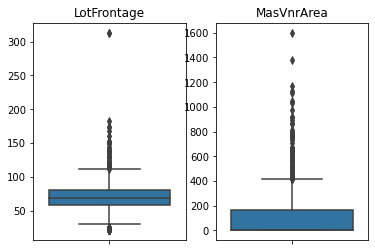

In [17]:
#Imputing sur les variables continues : 

fig,axe = plt.subplots(1,2)

for i,k in enumerate(var_true_NA_cont):
    ax = sns.boxplot(y = df[k], ax= axe[i])
    ax.set_title(k)
    ax.set_ylabel(None)
plt.show()


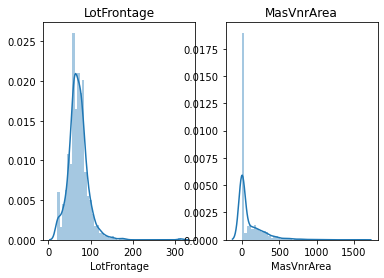

In [18]:
fig,axe = plt.subplots(1,2)

for i,k in enumerate(var_true_NA_cont):
    ax = sns.distplot(df[k], ax= axe[i])
    ax.set_title(k)
    ax.set_ylabel(None)
plt.show()


In [19]:
#beaucoup d'outliers, remplaçont par la médiane : 
for i in var_true_NA_cont:
    med = df[i].median()
    df[i] = df[i].fillna(med)

GarageYrBlt


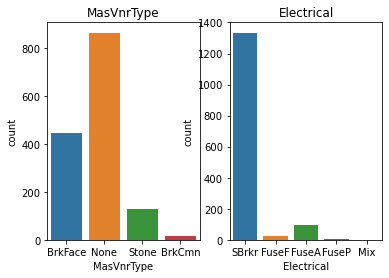

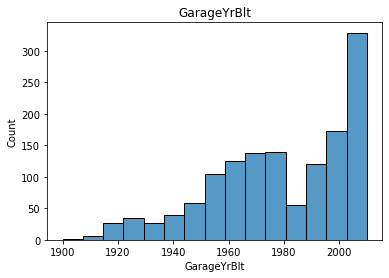

In [20]:
#Imputing sur les variables continues : 
fig,axe = plt.subplots(1,2)

for i,k in enumerate(var_true_NA_cat):
    if df[var_true_NA_cat[i]].nunique()<10:
        ax = sns.countplot(df[k], ax= axe[i])
        ax.set_title(k)
    else:
        print(k)

fig,axe = plt.subplots(1)
bx = sns.histplot(x = df.GarageYrBlt)
bx.set_title('GarageYrBlt')
        
plt.show()



In [21]:
#remplacement des NaN par le mode :
for i in var_true_NA_cat:
    mode = df[i].mode()[0]
    df[i] = df[i].fillna(mode)

In [22]:
#Toutes les valeurs manquantes ont été remplacées
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

# 3 Analyse bivariée : 

### 3.1 Target vs features continues : **heatmap**

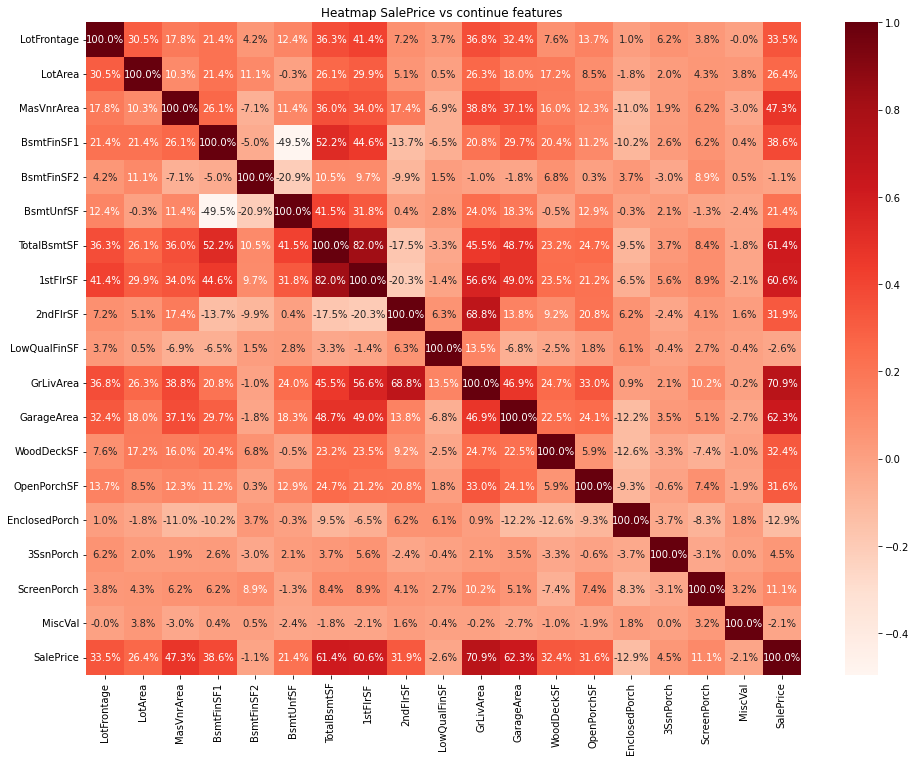

In [23]:
plt.figure(figsize=(16,12))
ax = sns.heatmap(df[var_cont].corr(), fmt = ".1%", annot = True, cmap='Reds')
ax.set_title("Heatmap SalePrice vs continue features ")
plt.show()

Récupération des meilleures features : 

In [24]:
#methode 1 en utilisation unstack : 
corr_feat = abs(df[var_cont].corr().unstack())
print("Liste des features les plus pertinentes : ")
corr_feat[corr_feat>0.5]['SalePrice']


Liste des features les plus pertinentes : 


TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageArea     0.623431
SalePrice      1.000000
dtype: float64

In [30]:
#methode 2 : plus classique sans unstack 
target = df['SalePrice']

corr_feat_2 = abs(df[var_cont].corr()[target.name] )
print("Liste des features les plus pertinentes : ")
corr_feat_2[corr_feat_2>0.5]

Liste des features les plus pertinentes : 


TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageArea     0.623431
SalePrice      1.000000
Name: SalePrice, dtype: float64

In [31]:
#l'ancienne liste des variables continues sera remplacée par les nouvelles variables les plus pertinentes : 
var_cont = list(corr_feat_2[corr_feat_2>0.5].index)
var_cont

['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 'SalePrice']

### 3.2 target vs features catégoriques : **boxplot**

In [32]:
print("Nombre de boxplot a faire : ", len(var_cat)) 

Nombre de boxplot a faire :  62


In [33]:
var_cat_1 = var_cat[:16]
var_cat_2 = var_cat[16:32]
var_cat_3 = var_cat[32:48]
var_cat_4 = var_cat[48:]

In [34]:
#### Creation d'une fonction qui affiche des boxplots : 

def quick_bp(nb_col, nb_ligne, dataframe, features,targ):
    
    fig, axe = plt.subplots(nb_col, nb_ligne, figsize=(18,18))
    
    for i, k in enumerate(dataframe[features]):
        nrow, ncol = i//nb_ligne, i%nb_ligne
        ax = sns.boxplot(x = k, y = targ, ax = axe[nrow,ncol], 
                    data=dataframe)
        ax.set_xlabel(None)
        ax.set_title(f'Analyse de {k} ({i})', fontdict = {"color":"red"})


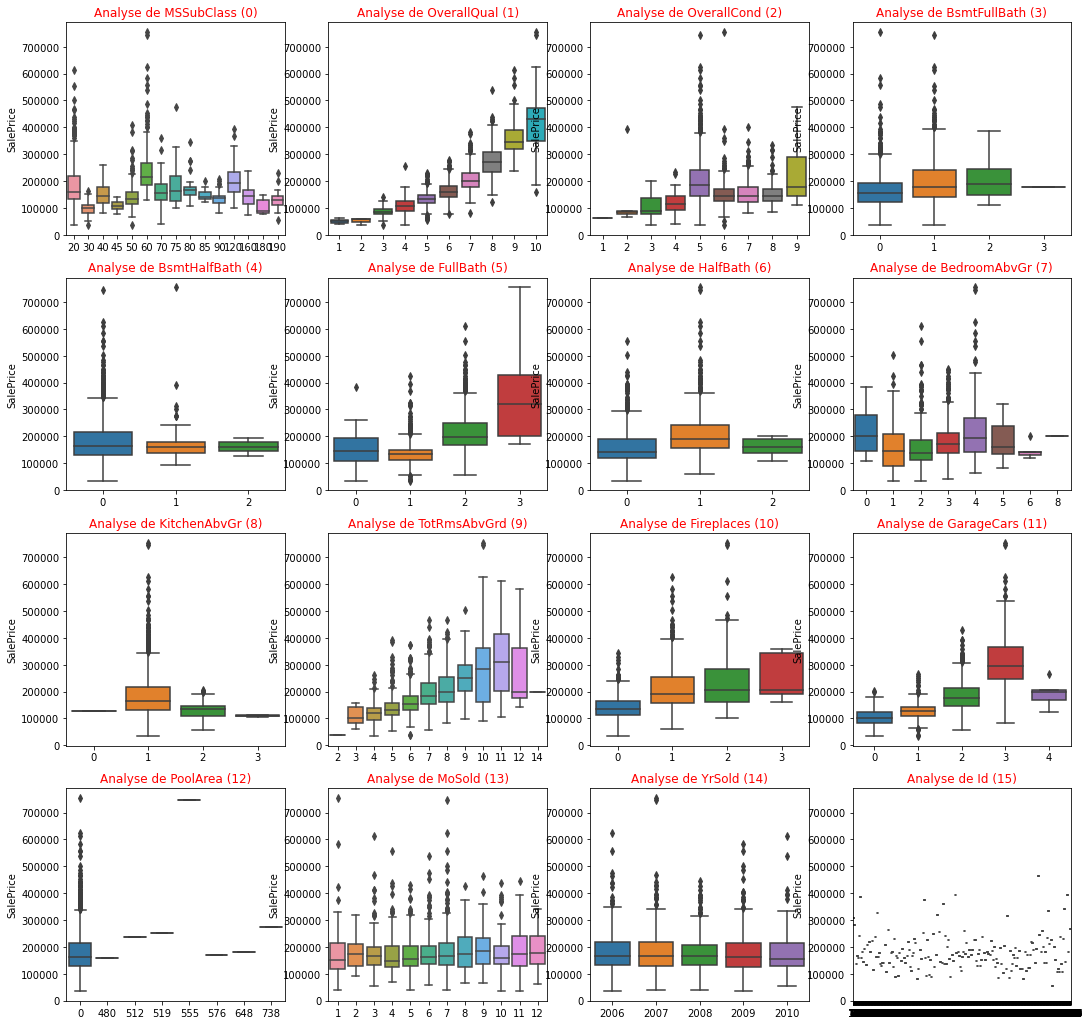

In [35]:
quick_bp(4,4,df, var_cat_1, target)

- **Observations :**

- **Mediane varie** en fonction de la target pour les features suivantes (on va donner la liste des indices pour gagner du temps) :
    - 0,1,2,3,5,6,7,8,9,10,11
        - **Conlusion** : on **rejette** l'hypothèse **H0** (égalité des médianes) et on **accepte H1**
- La médiane ne varie pas en fonction de la target pour les autres features, donc on peut les **supprimer** 

* On va utiliser une comprehension liste afin de supprimer **garder** uniquement les elements d'intérêts.
* ci-dessus on a afficher des boxplots avec leur indice dans la liste, on veut uniquement garder les indices suivants : 


In [36]:
var_cat_1_i = [0,1,2,3,5,6,7,8,9,10,11]
var_cat_1 = [k for i, k in enumerate(var_cat_1) if i in var_cat_1_i ]

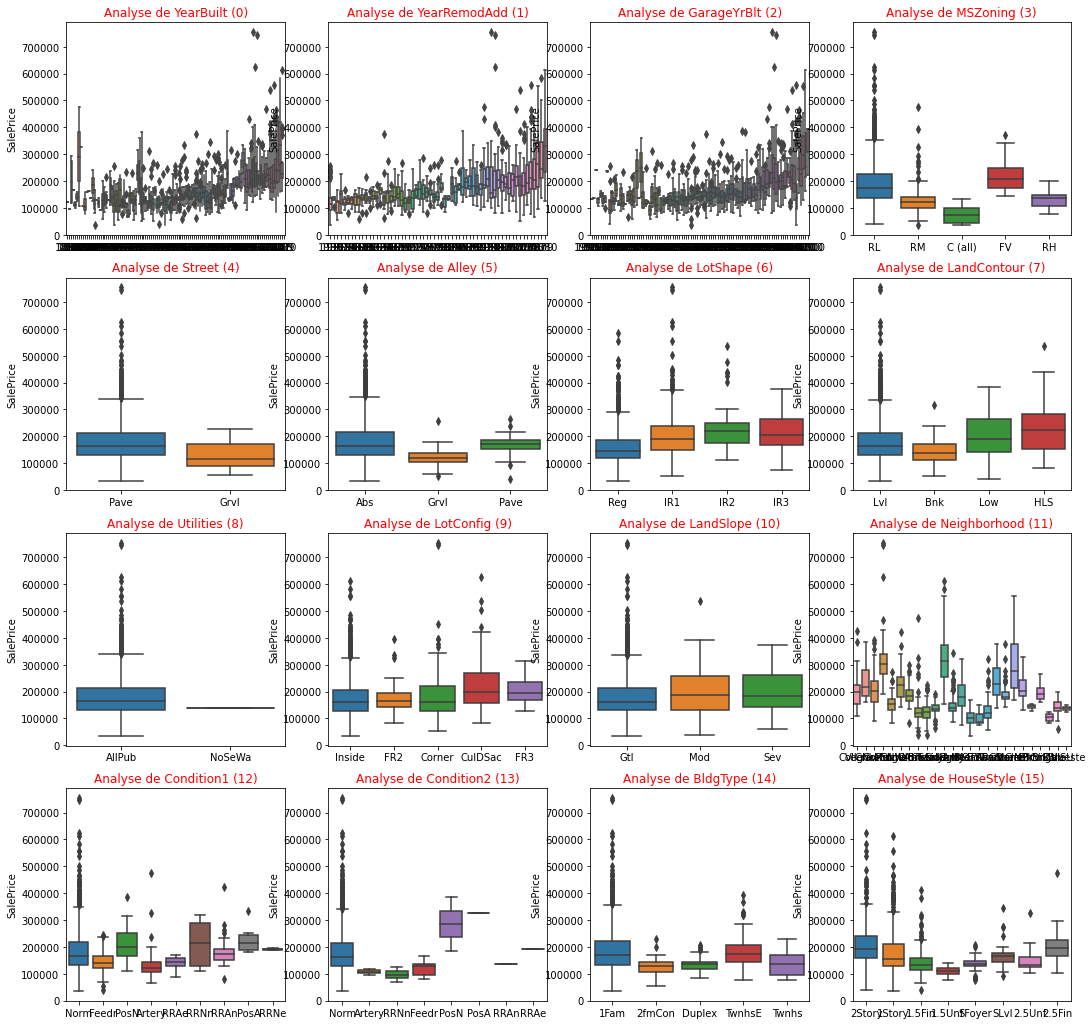

In [37]:
quick_bp(4,4,df, var_cat_2, target)

- **Observations :**

- **Mediane varie** en fonction de la target pour les features suivantes : 
    - 0,1,2,3,4,5,6,7,9,11,12,13,14,15
        - Conlusion : on **rejette** l'hypothèse **H0** (égalité des médianes) et on **accepte H1**
- La médiane ne varie pas en fonction de la target pour les autres features, donc on peut les **supprimer** 

In [38]:
var_cat_2_i = [0,1,2,3,4,5,6,7,9,11,12,13,14,15]
var_cat_2 = [k for i, k in enumerate(var_cat_2) if i in var_cat_2_i ]

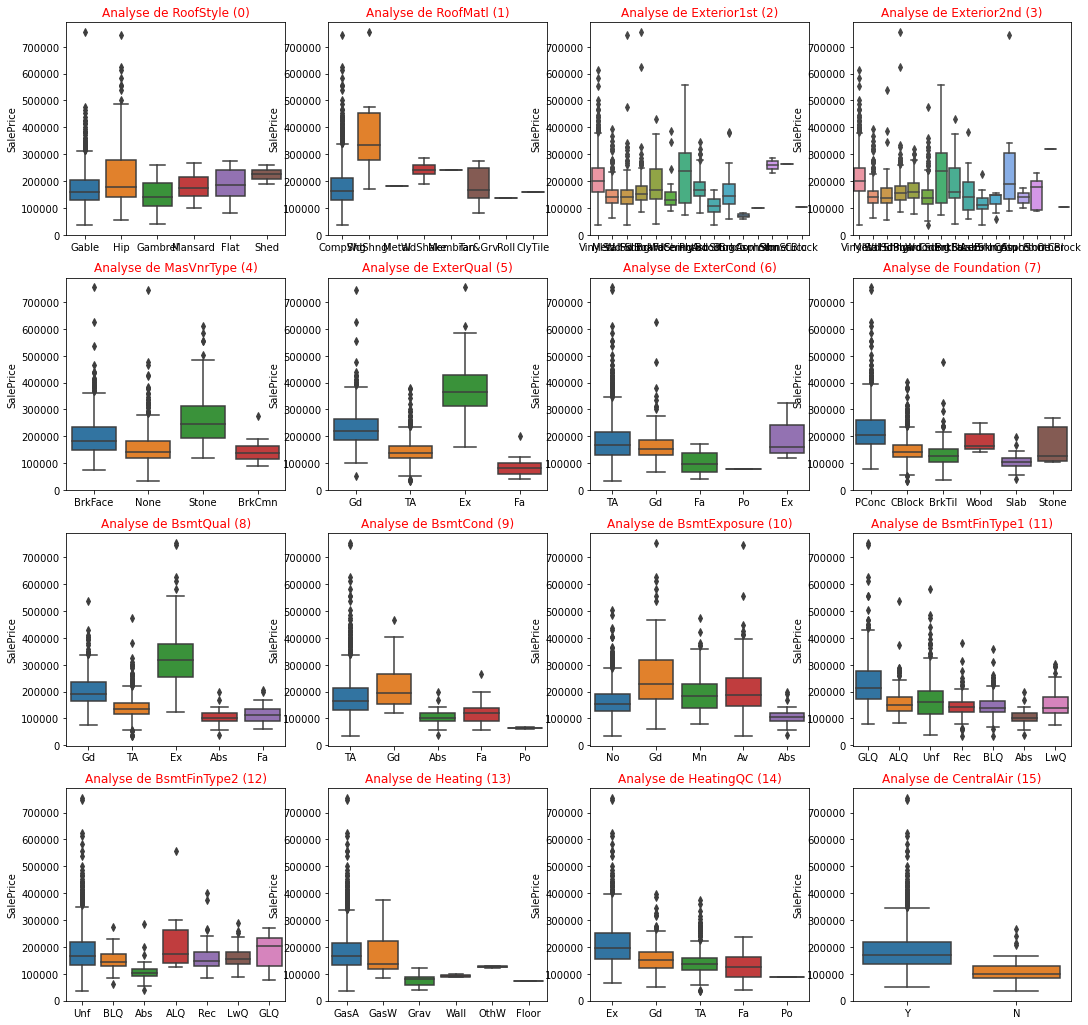

In [39]:
quick_bp(4,4,df, var_cat_3, target)

- **Observations :**

- **Mediane varie** en fonction de la target pour les features suivantes : 
    - l'ensembles des éléments
        - Conlusion : on **rejette** l'hypothèse **H0** (égalité des médianes) et on **accepte H1** pour toutes les variables.

In [40]:
#var_cat_3 restera intacte

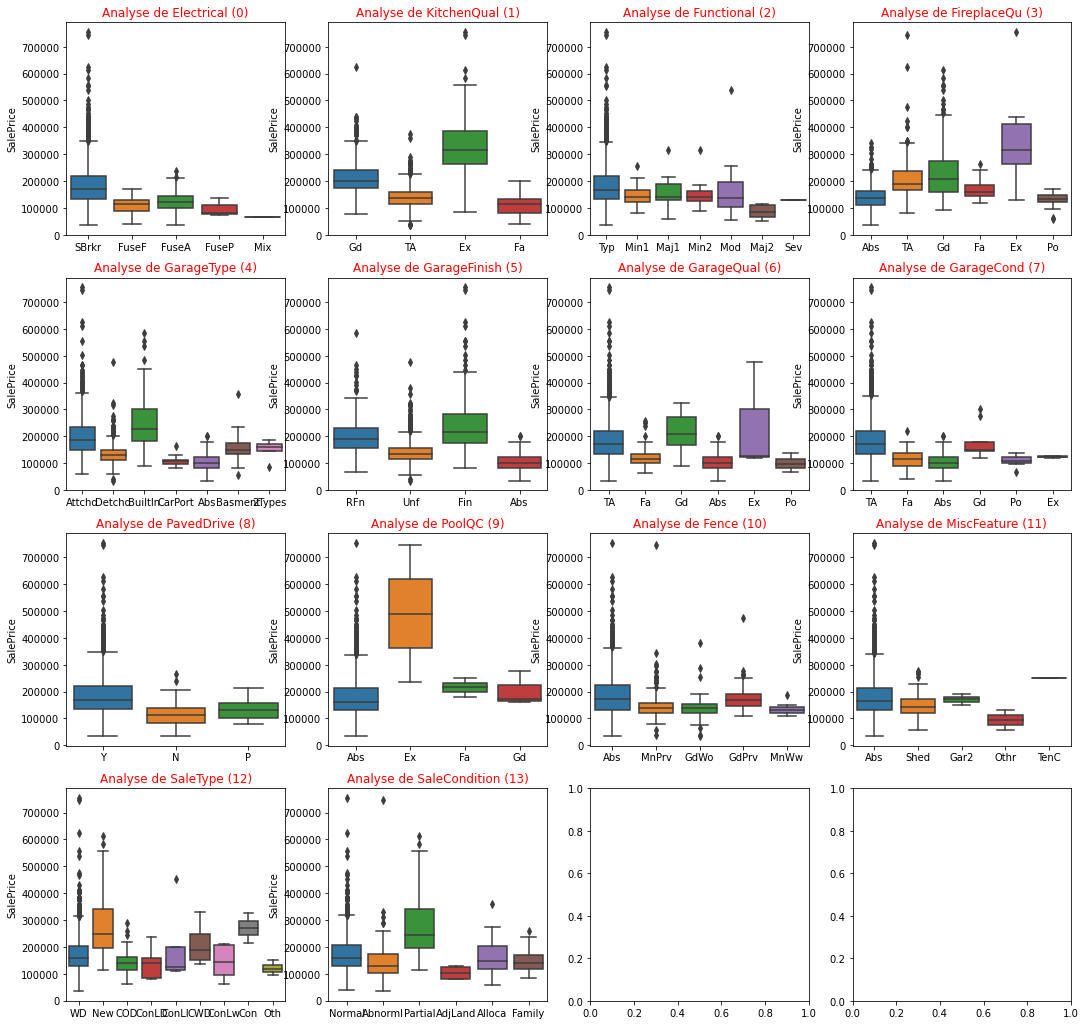

In [41]:
quick_bp(4,4,df, var_cat_4, target)

- **Observations :**

- **Mediane varie** en fonction de la target pour les features suivantes : 
    - l'ensembles des features
        - Conlusion : on **rejette** l'hypothèse **H0** (égalité des médianes) et on **accepte H1** pour toutes les features comme var_cat_3

In [42]:
var_cat = var_cat_1+var_cat_2+var_cat_3+var_cat_4
print("Nous avions au départ",df.shape[1], "variables")
print("Désormais nous en avons", len(var_cat))
print("Soit un suppression de", df.shape[1]-len(var_cat),"variables")

Nous avions au départ 81 variables
Désormais nous en avons 55
Soit un suppression de 26 variables


Nous avons récupérer l'ensemble des variables nécessaires a la mise en place de notre modèle

In [43]:
var_tot = var_cat + var_cont

In [44]:
#on garde le df uniquement avec les colonnes d'intérêts : 
df = df[var_tot]

Maintenant que nous avons récupérer l'ensembles des features les plus pertinentes pour notre target, il va falloir passer a l'encodage des données ainsi qu'a leur normalisation.


## 4. Encodage & normalisation des données
### Encodage des variables qualitatives
- Rappelons que nos variables catégoriques contiennent l'ensemble des variables numériques discrètes et les variables qualitatives
- On va recuperer uniquement les variables qualitatives **apres** selection

In [45]:
#Mise a jour de la variable var_qual : 
#on garde uniquement les variable qualitatives qu'on a filtré grace aux boxplots
var_qual = [i for i in var_cat if i  in var_qual] 

In [46]:
#on peut aussi mettre a jour var_dis : 
var_dis = [i for i in var_cat if i  in var_dis]

In [47]:
#df avant encodage 
df.head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,...,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,60,7,5,1,2,1,3,1,8,0,...,Abs,Abs,Abs,WD,Normal,856,856,1710,548,208500
1,20,6,8,0,2,0,3,1,6,1,...,Abs,Abs,Abs,WD,Normal,1262,1262,1262,460,181500
2,60,7,5,1,2,1,3,1,6,1,...,Abs,Abs,Abs,WD,Normal,920,920,1786,608,223500
3,70,7,5,1,1,0,3,1,7,1,...,Abs,Abs,Abs,WD,Abnorml,756,961,1717,642,140000
4,60,8,5,1,2,1,4,1,9,1,...,Abs,Abs,Abs,WD,Normal,1145,1145,2198,836,250000


In [48]:
### Encodage 
encoder = OrdinalEncoder()
df[var_qual] = encoder.fit_transform(df[var_qual])


In [49]:
pd.set_option("display.max_columns", None)

In [50]:
#df apres encodage :
df.head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuilt,YearRemodAdd,GarageYrBlt,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,60,7,5,1,2,1,3,1,8,0,2,2003,2003,2003.0,3.0,1.0,0.0,3.0,3.0,4.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,3.0,4.0,4.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,0.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,856,856,1710,548,208500
1,20,6,8,0,2,0,3,1,6,1,2,1976,1976,1976.0,3.0,1.0,0.0,3.0,3.0,2.0,24.0,1.0,2.0,0.0,2.0,1.0,1.0,8.0,8.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,0.0,6.0,1.0,0.0,1.0,4.0,3.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,1262,1262,1262,460,181500
2,60,7,5,1,2,1,3,1,6,1,2,2001,2002,2001.0,3.0,1.0,0.0,0.0,3.0,4.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,3.0,4.0,3.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,920,920,1786,608,223500
3,70,7,5,1,1,0,3,1,7,1,3,1915,1970,1998.0,3.0,1.0,0.0,0.0,3.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,15.0,2.0,3.0,4.0,0.0,4.0,2.0,4.0,0.0,6.0,1.0,2.0,1.0,4.0,2.0,6.0,3.0,6.0,3.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,0.0,756,961,1717,642,140000
4,60,8,5,1,2,1,4,1,9,1,3,2000,2000,2000.0,3.0,1.0,0.0,0.0,3.0,2.0,15.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,3.0,4.0,1.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,1145,1145,2198,836,250000


In [51]:
df.dtypes
#il n'y a plus aucunes colonnes de types object/str

MSSubClass         int64
OverallQual        int64
OverallCond        int64
BsmtFullBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
YearBuilt          int64
YearRemodAdd       int64
GarageYrBlt      float64
MSZoning         float64
Street           float64
Alley            float64
LotShape         float64
LandContour      float64
LotConfig        float64
Neighborhood     float64
Condition1       float64
Condition2       float64
BldgType         float64
HouseStyle       float64
RoofStyle        float64
RoofMatl         float64
Exterior1st      float64
Exterior2nd      float64
MasVnrType       float64
ExterQual        float64
ExterCond        float64
Foundation       float64
BsmtQual         float64
BsmtCond         float64
BsmtExposure     float64
BsmtFinType1     float64
BsmtFinType2     float64
Heating          float64
HeatingQC        float64


###  Séparation du jeu de données en train et test set
- Afin de pouvoir normaliser correctement nous devons au préalablement séparer notre jeu de données :

In [52]:
X, y = df.drop('SalePrice', axis = 1), df.SalePrice
var_cont.remove('SalePrice')

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
#on créé une copie du X_train/test pour pouvoir avoir l'ensemble des colonnes
normalized_train, normalized_test = X_train.copy(), X_test.copy()

### normalisation des données numériques continues sur la base du train set


In [55]:
#ensuite on va transformer uniquement les features continues : 
normalized_train[var_cont] = (X_train[var_cont]-X_train[var_cont].mean())/X_train[var_cont].std()
normalized_test[var_cont] = (X_test[var_cont]-X_train[var_cont].mean())/X_train[var_cont].std()

In [56]:
normalized_train.head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuilt,YearRemodAdd,GarageYrBlt,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
254,20,5,6,1,1,0,3,1,5,0,1,1957,1957,1957.0,3.0,1.0,0.0,3.0,3.0,4.0,12.0,2.0,2.0,0.0,2.0,1.0,1.0,8.0,8.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,5.0,6.0,1.0,4.0,1.0,4.0,3.0,6.0,0.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,0.572367,0.374075,-0.406919,-0.863467
1066,60,6,7,0,2,1,3,1,7,1,2,1993,1994,1993.0,3.0,1.0,0.0,0.0,3.0,4.0,8.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,2.0,2.0,4.0,2.0,3.0,4.0,4.0,6.0,6.0,1.0,2.0,1.0,4.0,3.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.596291,-0.957792,0.083135,-0.456069
638,30,5,7,0,1,0,2,1,4,0,0,1910,1950,2005.0,3.0,1.0,0.0,3.0,3.0,4.0,7.0,1.0,2.0,0.0,2.0,1.0,1.0,8.0,14.0,2.0,3.0,4.0,1.0,2.0,4.0,4.0,6.0,6.0,1.0,2.0,1.0,0.0,3.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,8.0,4.0,-0.603099,-0.965550,-1.394653,-2.256203
799,50,5,7,1,1,1,3,1,7,2,1,1937,1950,1939.0,3.0,1.0,0.0,3.0,3.0,0.0,18.0,1.0,2.0,0.0,0.0,1.0,1.0,13.0,14.0,1.0,3.0,4.0,0.0,3.0,4.0,4.0,0.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,5.0,6.0,3.0,5.0,5.0,2.0,0.0,3.0,0.0,8.0,4.0,-0.750599,-0.487113,0.458779,-1.119276
380,50,5,6,0,2,0,3,1,6,1,1,1924,1950,1924.0,3.0,1.0,2.0,3.0,3.0,4.0,18.0,2.0,2.0,0.0,0.0,1.0,1.0,3.0,14.0,2.0,3.0,4.0,0.0,4.0,4.0,4.0,4.0,6.0,1.0,4.0,1.0,4.0,2.0,6.0,3.0,6.0,3.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.081174,-0.370736,0.311953,-0.797147


In [57]:
normalized_test.head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuilt,YearRemodAdd,GarageYrBlt,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
892,20,6,8,0,1,0,3,1,6,0,1,1963,2003,1963.0,3.0,1.0,0.0,3.0,3.0,4.0,19.0,2.0,2.0,0.0,2.0,3.0,1.0,6.0,6.0,2.0,3.0,4.0,1.0,4.0,4.0,4.0,3.0,6.0,1.0,4.0,1.0,4.0,3.0,6.0,0.0,2.0,2.0,5.0,5.0,2.0,0.0,3.0,0.0,8.0,4.0,-0.006289,-0.262118,-0.875997,-1.005583
1105,60,8,5,1,2,1,3,1,9,2,2,1994,1995,1994.0,3.0,1.0,0.0,0.0,3.0,0.0,15.0,2.0,2.0,0.0,5.0,1.0,1.0,6.0,6.0,1.0,2.0,4.0,2.0,1.0,4.0,1.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,0.910484,0.855099,2.087205,1.116680
413,30,5,6,0,1,0,2,1,5,1,2,1927,1950,1927.0,4.0,1.0,1.0,3.0,3.0,4.0,17.0,0.0,2.0,0.0,2.0,1.0,1.0,14.0,15.0,2.0,3.0,4.0,1.0,4.0,4.0,4.0,6.0,6.0,1.0,2.0,1.0,0.0,3.0,6.0,3.0,6.0,3.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.122020,-0.365564,-0.952270,-0.550813
522,50,6,7,0,2,0,3,1,7,2,2,1947,1950,1950.0,4.0,1.0,0.0,3.0,3.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,5.0,5.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,0.0,6.0,1.0,0.0,1.0,4.0,3.0,6.0,3.0,6.0,3.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.131097,-0.427631,0.260469,-0.266581
1036,20,9,5,1,2,0,2,1,6,1,3,2007,2008,2008.0,3.0,1.0,0.0,0.0,1.0,4.0,23.0,2.0,2.0,0.0,2.0,3.0,1.0,12.0,13.0,3.0,2.0,4.0,2.0,1.0,4.0,2.0,3.0,6.0,1.0,0.0,1.0,4.0,0.0,6.0,1.0,2.0,1.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,1.266754,1.165437,0.176569,2.064119


Les données sont prêtes à être modéliser

# 5. Modélisation : 

## 5.1 Regression Linéaire : 

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [59]:
score_lr = np.sqrt(mean_squared_error(y_pred, y_test))
print(f"Prediction du prix à {score_lr:,.2f} $ près")

Prediction du prix à 34,901.91 $ près


## 5.2 KNN Regressor

In [60]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [61]:
score_knn = np.sqrt(mean_squared_error(y_pred_knn, y_test))
print(f"Prediction du prix à {score_knn:,.2f} $ près")

Prediction du prix à 43,124.71 $ près


#### Visualisation des prédictions KNN vs LinearRegression : 

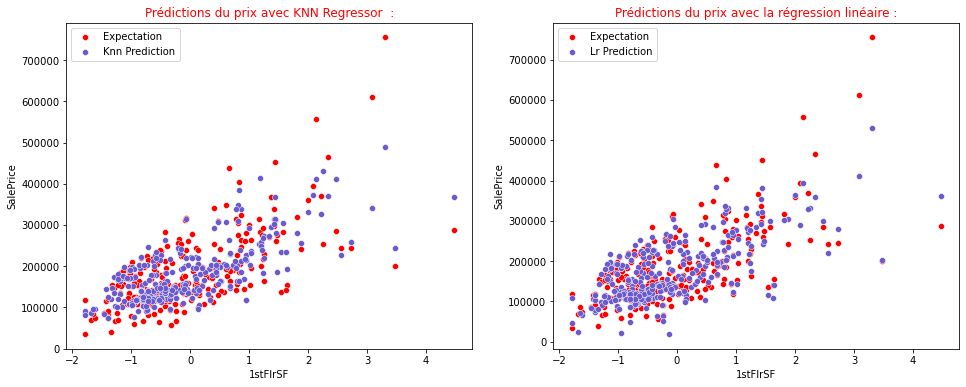

In [62]:
fig,axe = plt.subplots(1,2,figsize=(16,6))

# KNN regressor : 
ax = sns.scatterplot(x = normalized_test[var_cont[1]],y = y_test, 
                color = "red",label = "Expectation",
                ax = axe[0])
ax = sns.scatterplot(normalized_test[var_cont[1]], y_pred_knn, color = "slateblue", label = "Knn Prediction",
               ax = axe[0])
ax.set_title(f"Prédictions du prix avec KNN Regressor  :", fontdict={"color":"red"})
ax.legend(loc="upper left")


#Regression linéaire : 
ax = sns.scatterplot(x = normalized_test[var_cont[1]],y = y_test, 
                color = "red",label = "Expectation",
                ax = axe[1])
ax = sns.scatterplot(normalized_test[var_cont[1]], y_pred, color = "slateblue", label = "Lr Prediction",
               ax = axe[1])
ax.set_title(f"Prédictions du prix avec la régression linéaire :", fontdict={"color":"red"})
ax.legend(loc="upper left")


plt.show()

**Conclusion :**
- On a de meilleur résultat avec la régression linéaire, par conséquent nous allons essayer de l'améliorer.

# 6 Amélioration du modèle
- On va utiliser d'autres axes qui vont nous permettre d'améliorer le modèle : 
    - la cross validation au lieu du train test split
    - **Pas de GridSearchCV** (car il n'y a pas d'optimisation d'hyper parametre pour la regression linéaire)
    - rfe (selection des best features) 
## 6.1 Utilisation de la cross validation
- Pour la cross validation, il va falloir repartir de nos données avant séparations, puis les normaliser

In [63]:
X_normalized = X.copy()

In [64]:
X_normalized[var_cont] = (X_normalized[var_cont] - X_normalized[var_cont].mean()) / X_normalized[var_cont].std()

In [65]:
X_normalized

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuilt,YearRemodAdd,GarageYrBlt,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
0,60,7,5,1,2,1,3,1,8,0,2,2003,2003,2003.0,3.0,1.0,0.0,3.0,3.0,4.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,3.0,4.0,4.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,0.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.459145,-0.793162,0.370207,0.350880
1,20,6,8,0,2,0,3,1,6,1,2,1976,1976,1976.0,3.0,1.0,0.0,3.0,3.0,2.0,24.0,1.0,2.0,0.0,2.0,1.0,1.0,8.0,8.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,0.0,6.0,1.0,0.0,1.0,4.0,3.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,0.466305,0.257052,-0.482347,-0.060710
2,60,7,5,1,2,1,3,1,6,1,2,2001,2002,2001.0,3.0,1.0,0.0,0.0,3.0,4.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,3.0,4.0,3.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.313261,-0.627611,0.514836,0.631510
3,70,7,5,1,1,0,3,1,7,1,3,1915,1970,1998.0,3.0,1.0,0.0,0.0,3.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,15.0,2.0,3.0,4.0,0.0,4.0,2.0,4.0,0.0,6.0,1.0,2.0,1.0,4.0,2.0,6.0,3.0,6.0,3.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,0.0,-0.687089,-0.521555,0.383528,0.790533
4,60,8,5,1,2,1,4,1,9,1,3,2000,2000,2000.0,3.0,1.0,0.0,0.0,3.0,2.0,15.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,3.0,4.0,1.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,0.199611,-0.045596,1.298881,1.697903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,5,0,2,1,3,1,7,1,2,1999,2000,1999.0,3.0,1.0,0.0,3.0,3.0,4.0,8.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,2.0,3.0,4.0,2.0,3.0,4.0,4.0,6.0,6.0,1.0,0.0,1.0,4.0,3.0,6.0,5.0,2.0,2.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,-0.238040,-0.542249,0.250316,-0.060710
1456,20,6,6,1,2,0,3,1,7,2,2,1978,1988,1978.0,3.0,1.0,0.0,3.0,3.0,4.0,14.0,2.0,2.0,0.0,2.0,1.0,1.0,9.0,10.0,3.0,3.0,4.0,1.0,3.0,4.0,4.0,0.0,5.0,1.0,4.0,1.0,4.0,3.0,2.0,5.0,2.0,3.0,5.0,5.0,2.0,0.0,3.0,0.0,8.0,4.0,1.104547,2.354894,1.061003,0.126376
1457,70,7,9,0,2,0,4,1,9,2,1,1941,2006,1941.0,3.0,1.0,0.0,3.0,3.0,4.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,5.0,5.0,2.0,0.0,2.0,4.0,4.0,2.0,4.0,3.0,6.0,1.0,0.0,1.0,4.0,2.0,6.0,3.0,2.0,2.0,5.0,5.0,2.0,0.0,1.0,3.0,8.0,4.0,0.215567,0.065634,1.569110,-1.033560
1458,20,5,6,1,1,0,2,1,5,0,1,1950,1996,1950.0,3.0,1.0,0.0,3.0,3.0,4.0,12.0,2.0,2.0,0.0,2.0,3.0,1.0,8.0,8.0,2.0,3.0,4.0,1.0,4.0,4.0,3.0,3.0,5.0,1.0,2.0,1.0,0.0,2.0,6.0,0.0,2.0,3.0,5.0,5.0,2.0,0.0,0.0,0.0,8.0,4.0,0.046889,-0.218907,-0.832502,-1.089686


In [66]:
cross = KFold(n_splits=5,  shuffle=True, random_state=42)

In [67]:
cross_val_lr_standard = cross_val_score(estimator=LinearRegression(), X=X_normalized, y=y, 
                scoring="neg_mean_squared_error", cv=cross)

In [68]:
print("Estimation d'une maison à ",np.sqrt(abs(cross_val_lr_standard)).mean(), "$")
#on observe un résultat moins bon qu'avec le train_test_split, on va améliorer le nombre de split 

Estimation d'une maison à  35904.365698050555 $


In [69]:
#Recherche du split optimum pour KFold : 

Kfold_dic = {} 

for i in range(2,10):
    cross = KFold(n_splits=i,  shuffle=True, random_state=42)
    
    cross_val_lr = abs(cross_val_score(estimator=LinearRegression(), 
                                       X=X_normalized, y=y, 
                                       scoring="neg_mean_squared_error", cv=cross))
    
    rmse = np.sqrt(cross_val_lr).mean()
    print(f'pour {i} split, rmse = {rmse}')
    
    #on recupere le cross pour chaque split, et on prendra les parametres pour lesquelles on retrouvera le min(rmse)
    Kfold_dic[i] = cross

pour 2 split, rmse = 36832.80551517679
pour 3 split, rmse = 36787.869500810404
pour 4 split, rmse = 35425.493572522144
pour 5 split, rmse = 35904.365698050555
pour 6 split, rmse = 35193.41481387107
pour 7 split, rmse = 35190.92876232988
pour 8 split, rmse = 34576.12849415005
pour 9 split, rmse = 35459.98012552982


In [70]:
#Meilleur parametre Kfold cross validation : 
best_kfold = Kfold_dic[8]

best_rmse_cross_val_lr = np.sqrt(abs(cross_val_score(estimator=LinearRegression(), 
                                       X=X_normalized, y=y, 
                                       scoring="neg_mean_squared_error", cv=best_kfold))).mean()

In [71]:
print(f" RMSE train_test_split : {score_lr:,.2f} \n RMSE cross_val_score :{best_rmse_cross_val_lr:,.2f}")
print(f"Soit une amélioration de la prédiction de : {score_lr-best_rmse_cross_val_lr:,.2f} $")

 RMSE train_test_split : 34,901.91 
 RMSE cross_val_score :34,576.13
Soit une amélioration de la prédiction de : 325.78 $


## 6.2 RFE
- Maintenant que nous avons trouver les paramètres qui permettent de **minimiser** le rmse, on va regarder quel est le nombre de features a garder pour minimiser le rmse :

In [72]:
model_with_scores = {}

for i in range(1,X_normalized.shape[1]):
    rfe = RFE(estimator=LinearRegression(),n_features_to_select=i)
    model = LinearRegression()
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    
    cv = best_kfold  #on va utiliser le kfold qui a permis d'obtenir les meilleurs resultats
    n_scores = cross_val_score(pipeline, X= X_normalized, y=y, cv=cv, scoring="neg_mean_squared_error")
    
    #report performance
    
    print(abs(n_scores)**0.5)
    print(np.mean(abs(n_scores)**0.5))
    model_with_scores[pipeline]=np.mean(abs(n_scores)**0.5) 
                      

[56776.39866277 70366.08898721 87293.64520405 73899.54375314
 82927.46013027 75557.31787827 65414.37657435 44414.34469916]
69581.14698615334
[47954.47542435 48161.81830789 68785.33310816 56020.63246319
 69150.99105632 63138.91182728 65095.02949287 44700.21886013]
57875.92631752511
[47600.56002692 50025.9767507  68736.38022851 50044.48870549
 55434.31773289 62633.05568168 42850.60814782 37168.83623402]
51811.7779385014
[47421.38016328 50020.62041728 68975.11989983 50260.21991347
 55717.90127906 44222.29272741 36205.12454191 36078.53401507]
48612.64911966241
[46285.89157094 42075.98905688 48472.1803489  43903.14432595
 52311.76027978 44170.08662321 35903.54845872 35873.65959858]
43624.53253286971
[43337.47780664 38714.10296431 46717.34138896 41108.31502648
 51084.21108019 42369.40284674 35928.97791962 35901.63259142]
41895.182703044266
[43130.14071749 36805.2986936  41662.47444833 41005.03205576
 55235.69634458 33964.28045352 32748.11205842 32989.8249056 ]
39692.607459661784
[43280.93061

In [73]:
#Utilisation du meilleur modèle en triant par ordre croissant (pour avoir la valeur la plus proche de 0 en premier)
models  = list(sorted(model_with_scores.items(), key=lambda item: item[1]))

In [74]:
best_model =  models[0][0]
best_model.fit(X_normalized,y)
#use it to predict for new data

Pipeline(steps=[('s',
                 RFE(estimator=LinearRegression(), n_features_to_select=51)),
                ('m', LinearRegression())])

In [75]:
best_model_rmse = models[0][1]

In [76]:
best_model

Pipeline(steps=[('s',
                 RFE(estimator=LinearRegression(), n_features_to_select=51)),
                ('m', LinearRegression())])

In [77]:
print(f" RMSE train_test_split : {score_lr:,.2f}$ \n RMSE cross_val_score :{best_rmse_cross_val_lr:,.2f}$")
print(f" RMSE RFE :{best_model_rmse:,.2f}$")
print(f"Soit une amélioration de {score_lr-best_model_rmse:,.2f}$ par rapport au train test split")

 RMSE train_test_split : 34,901.91$ 
 RMSE cross_val_score :34,576.13$
 RMSE RFE :34,471.09$
Soit une amélioration de 430.82$ par rapport au train test split


# Preprocessing du fichier test : 

In [145]:
path_test = 'D:\\formation_data_scientist\\01_Cours\\007_machine_learning\\004_Linear_Regression\\test.csv'
house_test = pd.read_csv(path_test)
df_test = house_test.copy()

In [146]:
var_tot.remove('SalePrice')

ValueError: list.remove(x): x not in list

In [147]:
# Récupération uniquement des colonnes utilisées 
df_test = df_test[var_tot]

# Nous aurons besoins des variables suivantes :
 
- var_cat
- var_qual
 avec var_cat = var_qual + var_dis

In [148]:
df_test.head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuilt,YearRemodAdd,GarageYrBlt,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
0,20,5,6,0.0,1,0,2,1,5,0,1.0,1961,1961,1961.0,RH,Pave,NaN,Reg,Lvl,Inside,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal,882.0,896,896,730.0
1,20,6,6,0.0,1,1,3,1,6,0,1.0,1958,1958,1958.0,RL,Pave,NaN,IR1,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal,1329.0,1329,1329,312.0
2,60,5,5,0.0,2,1,3,1,6,1,2.0,1997,1998,1997.0,RL,Pave,NaN,IR1,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal,928.0,928,1629,482.0
3,60,6,6,0.0,2,1,3,1,7,1,2.0,1998,1998,1998.0,RL,Pave,NaN,IR1,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal,926.0,926,1604,470.0
4,120,8,5,0.0,2,0,2,1,5,0,2.0,1992,1992,1992.0,RL,Pave,NaN,IR1,HLS,Inside,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,1280.0,1280,1280,506.0


#### Nettoyage des NaN : 
- Les NaN qu'il ne faut pas supprimer : 

In [149]:
var_NA_test = [i for i in df_test if i in var_NA]

In [150]:
df_test[var_NA_test] = df_test[var_NA_test].fillna('Abs')

Comme on a deja isoler et mis a jour nos variables var_cat et var_cont, nous n'avons plus besoin de refaire l'étape de la sélection de variables

In [151]:
#Récupération des features contenant des NA
var_true_na_test = list(df_test.isnull().sum()[df_test.isnull().sum()>0].index)
var_true_na_test

['BsmtFullBath',
 'GarageCars',
 'GarageYrBlt',
 'MSZoning',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'KitchenQual',
 'Functional',
 'SaleType',
 'TotalBsmtSF',
 'GarageArea']

In [152]:
# Récupération des variables contenant des NA et qui sont continues :
var_true_na_test_cont = [ i for i in var_true_na_test if (i in var_true_na_test) and (i in var_cont)]

In [153]:
# Récupération des variables contenant des NA et qui sont continues :

var_true_na_test_cat = [i for i in var_true_na_test if (i in var_true_na_test) and (i in var_cat)]

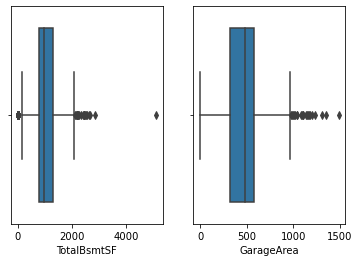

In [162]:
fig,axes = plt.subplots(1,2)
for i,k in enumerate(var_true_na_test_cont):
    ax = sns.boxplot(k, data = df_test, ax= axes[i])


In [172]:
for i in var_true_na_test_cont:
    mediane = df_test[i].median()
    df_test[i] = df_test[i].fillna(mediane)

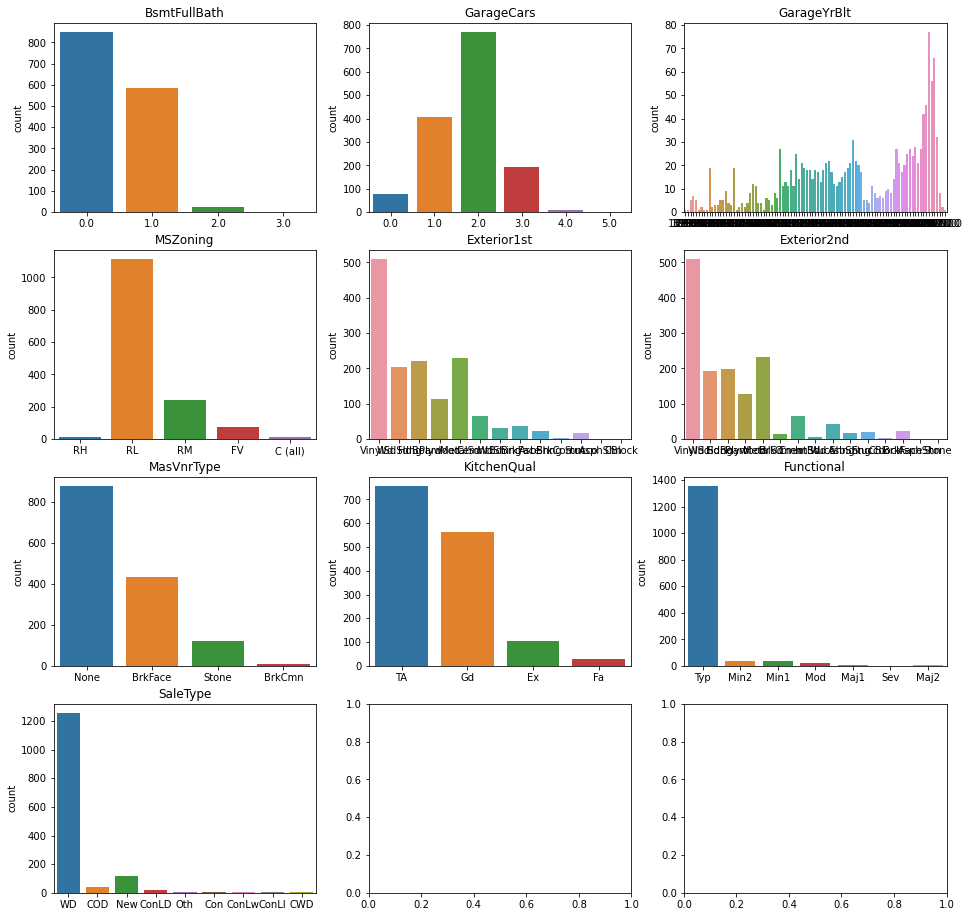

In [182]:
fig,axes = plt.subplots(4,3, figsize= (16,16))

for i,k in enumerate(var_true_na_test_cat):
    nrow,ncol = i//3, i%3
    ax = sns.countplot(k, data = df_test, ax= axes[nrow,ncol])
    ax.set_xlabel(None)
    ax.set_title(f'{k}')

In [185]:
df_test['GarageYrBlt'].nunique()

97